# DATA 602 Fall 2016 Final Project

# Author: James Topor

# Introduction

Sensor technology is rapidly changing the ways in which electricity consumption can be monitored and controlled while also improving the effectiveness of automated security systems. For example, home thermostats and lighting can now be programmed to activate according to the amount of daylight detected via an external light sensor, thereby ensuring that lighting and/or HVAC systems are deactivated when not needed. Motion sensors have also long been used in many commercial settings to control the activation and deactivation of lighting systems. However, a common shortcoming of motion detection systems is that they will deactivate a lighting system if they fail to detect sufficient motion within the space they are monitoring. As a result, individuals can find themselves suddenly cast into darkness while working at a desk or while using various public facilities.

Additional types of sensor technology are rapidly evolving to allow for their application to both energy management and security within both commercial and residential structures. As these technologies become both less expensive to use and easier to implement, building owners and energy management firms are exploring ways in which multiple types of sensors can be combined to more accurately control energy usage and/or improve building security.


# Research Question

As the use of additional types of sensors becomes practical on a widespread basis, a potential research question that can be posed is:

- Can the output from multiple types of sensors allow us to determine whether or not people are present within a room? 

If so, both energy management and security systems might benefit from the use of such sensors. For example, energy management systems could be refined so as to minimize the likelihood of a lighting system being turned off due to minimal motion of a room's occupants. Similarly, security systems could be further enhanced to allow for better detection of potential intruders.

Two researchers explored this question in a paper published earlier this year:
("__Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models__". Luis M. Candanedo, Varonique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39). 

The goal of this DATA 602 project is to apply some of Python's regression tools in an attempt to predict the occupancy of a room based on the output of a variety of different types of sensors.


# Methodology

The methodology used for addressing the research question consists of three separate workstreams: Data Exploration, Data Preparation, and Regression Modeling. The nature of each is described below:

- __Data Preparation__: Development of strategies for handling missing or invalid data values and development of an approach for the separation of the three provided data files into dedicated regression modeling "Training" and "Testing" subsets. Creation of separate training and testing data sets is necessary to allow for testing of regression models on a relatively unbiased set of data.

- __Data Exploration__: Investigation of the characteristics of each individual variable contained within the data set, including their data types, range of valid values, their distributions, and their correlations with one another.

- __Regression Modeling__: Identification, development, and testing of appropriate regression models. Since we are tasked with predicting a binary 'yes/no' status for the occupancy of a room, two binary logistic regression models and one linear model are evaluated in an attempt to identify that which was most effective at making such predictions. The "best" model is then selected on the basis of performance metrics including AIC score, AUC, accuracy, classification error rates, precision, specificity, sensitivity, and F1 scores. 

Subsequent to the development and selection of appropriate regression models, the 'best' model is applied to the evaluation data set. Results of the 'best' regression model are then compared against actual room occupancies to judge the model's effectiveness at predicting the response variable.

As a first step we load a set of required python packages and define two python functions to be used for loading and formatting of the training and test data sets. The specific formatting to be used is described in the __Data Preparation__ section below.

In [1]:
# load required python packages
%pylab inline
import pandas as pd
import csv
import numpy as np
import time
# import matplotlib.pyplot as plt

# for IPython table formatting
from IPython.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------

def bld_training() :
    """ This function reads two files from github that contain data to be used for training of the regression models into
    two separate dataframes.
    The first row of each file is ignored since it contains column names for only 7 of the 8 columns of 
    data provided. The first column of each file is also discarded since it contains a redundant index value that 
    is not needed for regression modeling. The 7 useful data columns are then assigned meaningful names 
    and the numeric columns are converted to floating point format. Finally, dataframes containing the content
    of the two separate files are combined and returned."""
    
    # read datatest.txt from github - file will be used for training data set
    # skip first row and discard first column
    filename = "https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatest.txt"
    df = pd.read_csv(filename, skiprows = 1, header=None, usecols=[1,2,3,4,5,6,7])

    # assign meaningful column names to data frame
    df.columns = ['date', 'temp', 'humidity', 'light', 'CO2', 'humidratio', 'occ']
    
    # convert numeric dataframe columns to float
    df[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']] = \
    df[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']].astype(float)
    
    # read datatest2.txt from github - file will be used for training data set
    # skip first row and discard first column
    filename = "https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatest2.txt"
    df2 = pd.read_csv(filename, skiprows = 1, header=None, usecols=[1,2,3,4,5,6,7])

    # assign meaningful column names to data frame
    df2.columns = ['date', 'temp', 'humidity', 'light', 'CO2', 'humidratio', 'occ']
    
    # convert numeric dataframe columns to float
    df2[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']] = \
    df2[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']].astype(float)
    
    # df2.dtypes
    
    # now append df2 to df
    df = df.append(df2, ignore_index = True)
    
    return(df)


In [3]:
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------

def bld_test() :
    """ This function reads a file from github that contains a set of data to be used for testing of 
    the regression models into a dataframe. The format of the data is identical to that used for training of the regression
    models. As such, as with the training data, the first row of the file is ignored since it contains column names
    for only 7 of the 8 columns of data provided. The first column is also discarded since it contains a redundant
    index value that is not needed for regression modeling. The 7 useful data columns are then assigned meaningful
    names and the numeric columns are converted to floating point format."""
    
    # read datatraining.txt from github - file will be used for testing data set
    # skip first row and discard first column
    filename = "https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatraining.txt"
    dft = pd.read_csv(filename, skiprows = 1, header=None, usecols=[1,2,3,4,5,6,7])

    # assign meaningful column names to data frame
    dft.columns = ['date', 'temp', 'humidity', 'light', 'CO2', 'humidratio', 'occ']
    
    # convert numeric dataframe columns to float
    dft[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']] = \
    dft[['temp','humidity', 'light', 'CO2', 'humidratio', 'occ']].astype(float)
    
    #df.dtypes
    return(dft)

# Part 1: Data Preparation

The data for this project was sourced from the University of California at Irvine's Machine Learning Repository. Specifically, the __Occupancy Detection Data Set__ is used, and is accessible via the following web link:

https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

The data set is comprised of a total of 20,563 cases spread across three files, with each case being comprised of six attributes and one response variable:

__Date__: A 19-character field comprised of the date and time of the recording of the case. The 19 character field is structured as follows:

    YYYY-MM-DD HH:MM:SS
    
where YYYY is the year (4 digits), MM is the month (2 digits), DD is the day (2 digits), HH is the hour (2 digits), MM is the minute (2 digits), and SS is the second (2 digits)

__Temperature__: The recorded room temperature in degrees Celsius.

__Relative Humidity__: The percentage relative humidity recorded within the room.

__Light__: The amount of light recorded within the room, expressed in terms of "lux". A lux equals one lumen incident per square meter of illuminated surface area.

__CO2__: The amount of carbon dioxide recorded within the room, measured in parts per million (ppm).

__Humidity Ratio__: A derived metric measured as (kilograms of water vapor / kilograms of air).

__Occupancy__: A binary 0/1 flag, with 0 indicative of the room not having been occupied and 1 indicative of the room having been occupied at the time of the measurements. This field represents the response variable for the observation.

Two of the provided data files will be used for model building/training while the third will be used for model testing. The formats of the three files are identical. A representative snapshot of one of these files is provided below:

![Image](DataFile.png)

NOTE: The three data files may be accessed via the following web links:

- https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatest.txt

- https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatest2.txt

- https://raw.githubusercontent.com/jtopor/CUNY-MSDA-602/master/Project/datatraining.txt

As we can see in the image shown above, all rows containing data are comprised of 8 separate values. However, the first row in the file contains appropriate names for only 7 of these 8 values. The first numeric value in each row of data is simply a redundant index value that is not required for our purposes. As such, when reading the contents of these files into a dataframe both the first row and the first column within each file is ignored. The resulting data frame is then comprised of only the 7 variables described above. Meaningful column names are also assigned to each column of the data frame, and the non-date values are all converted to 'float' format.

As mentioned above, the three files together provide a total of 20,563 observations. However, those observations are not equally distributed amongst the three files: the files contain 2665, 9752, and 8143 observations each, respectively. For purposes of regression analysis, the file containing 8143 observations (roughly 40% of the total) will be used for regression model testing while the remaining two files are combined into a single data frame comprised of 12,417 observations (roughly 60% of the total) that will be used for regression model training. 

The __build_training__ and __build_test__ functions defined above provide the required data preparation steps described here.  Once executed, the resulting dataframes can be used for regression analysis. However, as a preliminary step the statistical characterics of the various data variables are explored. The results of the __Data Exploration__ work described below provide useful insights for the construction of regression models.


# Part 2: Data Exploration

The training data set we are exploring is comprised of a series of timestamped readings from various types of sensors installed within an indoor space. The data set contains 12,417 observations, and for each observation we are provided with five non-date independent variables that could potentially be used as predictors and one response variable (`occ`) which indicates whether or not the indoor space was in fact occupied at the time of the observation. As an initial step in exploring the data set we can construct boxplots of each of the the five independent variables grouped by their corresponding 'occ' response variable values. Doing so allows us to gain some intuition regarding the relation of each independent variable to the binary response variable.

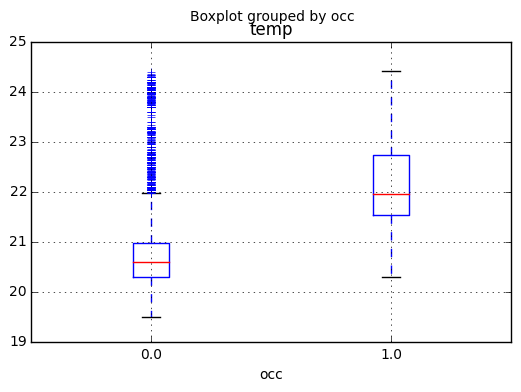

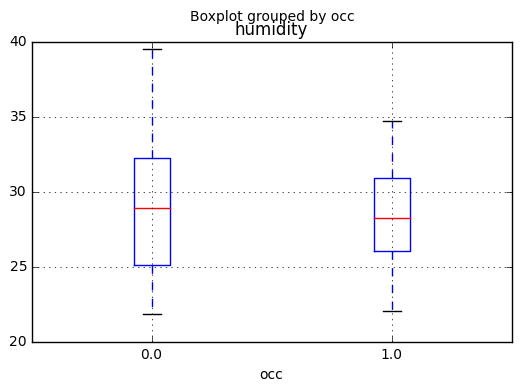

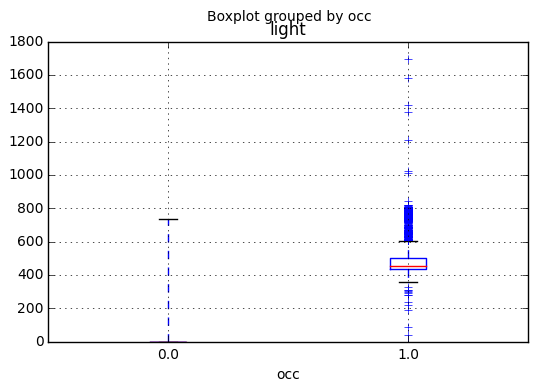

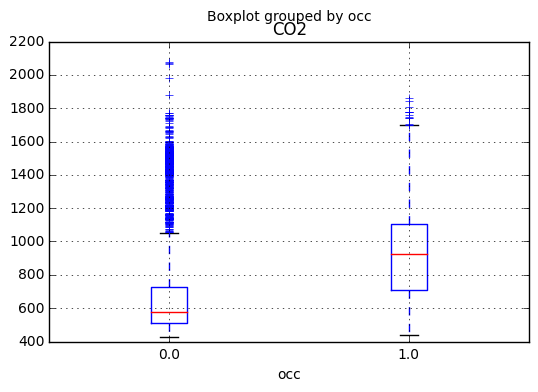

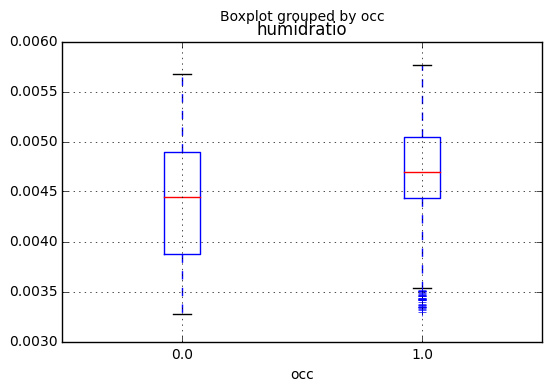

In [4]:
# load the regression model training and testing data
tr_df = bld_training()
test_df = bld_test()

# boxplots of each independent variable grouped by 'occ' value
tr_df.boxplot(column="temp", by= "occ")
tr_df.boxplot(column="humidity", by= "occ")
tr_df.boxplot(column="light", by= "occ")
tr_df.boxplot(column="CO2", by= "occ")
tr_df.boxplot(column="humidratio", by= "occ")

The boxplots show that, in general, relatively higher values for temperature ('temp'), light, CO2, and humidity ratio appear to be indicative of the indoor space being occupied. Conversely, higher values for humidity appear to coincide with the space being unoccupied. Such inferences can be used when constructing a predictive regression model. The plot for the 'light' variable also appears to indicate that that variable is zero-bound, a factor which may also prove relevant when attempting to construct a predictive model for the 'occ' response variable. 

A statistical summary of the independent variables is shown in the following table:

In [5]:
# display the summary table for the training data
display(tr_df.describe())

,temp,humidity,light,CO2,humidratio,occ
count,12417.000000,12417.000000,12417.000000,12417.000000,12417.000000,12417.000000
mean,21.094510,28.917947,138.125947,745.644624,0.004468,0.243295
std,1.037511,4.125142,219.801233,296.497310,0.000595,0.429089
min,19.500000,21.865000,0.000000,427.500000,0.003275,0.000000
25%,20.390000,25.390000,0.000000,527.500000,0.003988,0.000000
50%,20.790000,28.600000,0.000000,632.000000,0.004511,0.000000
75%,21.675000,31.790000,392.000000,857.000000,0.004942,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.005769,1.000000


The binary 0/1 nature of the 'occ' response variable is clearly evident in the table shown above. The summary shows that just over 24% of the observations contained within the training data set represent instances of an occupant actually having been present within the indoor space at the time of an observation. Furthermore, the table shows quite clearly that each of the prospective predictor variables (temp, humidity, light, CO2, and humidratio) are continuous in nature rather than discrete. 

The '50%' metric shown in the table represents the median value for each of the indicated variables. Comparing these values to their respective means indicates that the distributions of some of the variables are right-skewed. For example, the mean values of the 'temp', 'humidity', 'light', and 'CO2' variables all exceed their corresponding median values, a characteristic that is typically indicative of a right-skewed distribution. Boxplots and histograms for each of the potential predictor variables (see below) confirm the presence of such skew in the aforementioned distributions. A brief discussion of each predictor variable's distribution is provided below.

#### Temperature ('temp')

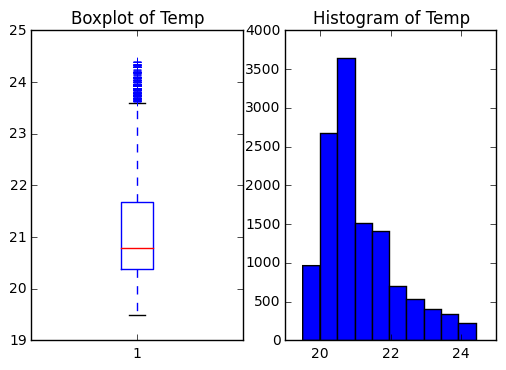

In [6]:
# boxplot and histogram of temp variable
plt.figure(1)
plt.subplot(121)
plt.boxplot(tr_df['temp'])
plt.title('Boxplot of Temp')
plt.xlabel(' ')
    
plt.subplot(122)
plt.hist(tr_df['temp'])
plt.title('Histogram of Temp')
plt.locator_params(nbins=5, axis = 'x')

plt.show()

The boxplot and histogram for the temperature variable ('temp') show clear evidence of a right-skewed distribution, thereby confirming the intuition regarding the fact that the mean value exceeding the median was indicative of such skew. However, it is unclear whether the skew is being caused by unusual outliers or by naturally occurring variations in temperature that result from factors such as seasonality or occupancy. 

#### Humidity ('humidity')

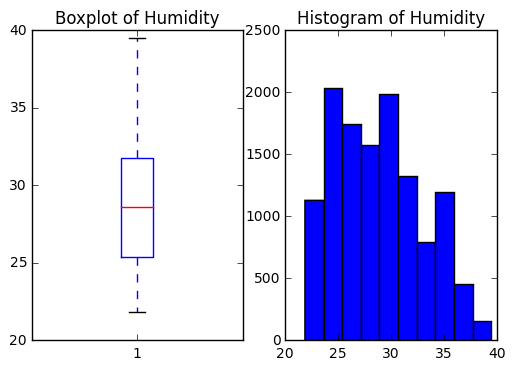

In [7]:
# boxplot and histogram of humidity variable
plt.figure(1)
plt.subplot(121)
plt.boxplot(tr_df['humidity'])
plt.title('Boxplot of Humidity')
plt.xlabel(' ')
    
plt.subplot(122)
plt.hist(tr_df['humidity'])
plt.title('Histogram of Humidity')
plt.locator_params(nbins=5, axis = 'x')
    
plt.show()

Plots of the humidity variable also provide clear evidence of right-skew for the distribution of that variable. Furthermore, the distribution shows evidence of being somewhat multi-modal as evidenced by the three distinct peaks shown in the histogram. As with the temperature data, it is unclear whether the skew (as well as the potential multi-modality) is being caused by unusual outliers or by naturally occurring variations in humidity that result from factors such as seasonality or occupancy.

#### Light ('light')

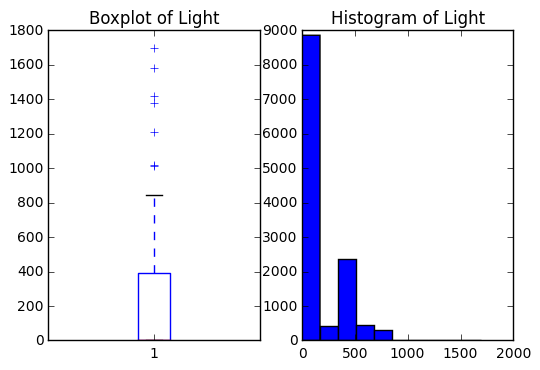

In [8]:
# boxplot and histogram of light variable
plt.figure(1)
plt.subplot(121)
plt.boxplot(tr_df['light'])
plt.title('Boxplot of Light')
plt.xlabel(' ')
    
plt.subplot(122)
plt.hist(tr_df['light'])
plt.title('Histogram of Light')
plt.locator_params(nbins=5, axis = 'x')
    
plt.show()

The light variable appears to be both right-skewed and bi-modal in nature. In fact, the table of summary statistics shown earlier indicates that the median value for 'light' is zero. As such, at least half (and likely more) of the values for the 'light' variable are zeroes. The bi-modal nature of 12,417 'light' variable values might partially be explained by whether the indoor space was occupied at the time of an observation. For example, we might expect the light sensor to detect zero light when the space is unoccupied. However, it is much less clear why there might be such a wide variation in the non-zero values of 'light'.

The bi-modal distribution indicates that the variable may be a good candidate for conversion to a binary '0/1' categorical variable for purposes of regression analysis. To facilitate such a conversion we need to first identify a threshold value that more or less bisects the bi-modal distribution into two distinct non-bimodal distributions.

As a first step in identifying such a threshold we isolate the non-zero values of the 'light' variable, yielding the following summary statistics and plots:

In [9]:
# isolate light values > 0
ltemp = tr_df['light'][tr_df['light'] > 0]
ltemp.describe()

count    4805.000000
mean      356.942744
std       216.201676
min         4.666667
25%       139.666667
50%       433.000000
75%       459.000000
max      1697.250000
Name: light, dtype: float64

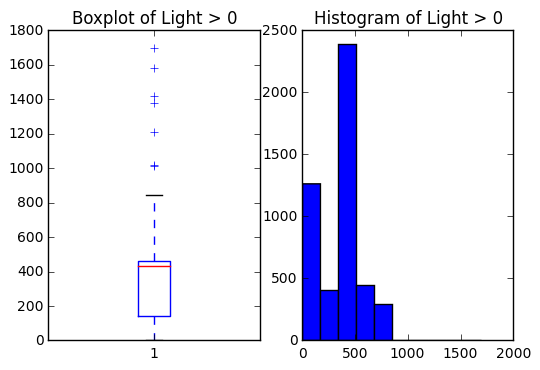

In [10]:
# boxplot and histogram of light values > 0
plt.figure(1)
plt.subplot(121)
plt.boxplot(ltemp)
plt.title('Boxplot of Light > 0')
plt.xlabel(' ')

plt.subplot(122)
plt.hist(ltemp)
plt.title('Histogram of Light > 0')
plt.locator_params(nbins=5, axis = 'x')

plt.show()

Of the 12,417 total observations contained within the training data set, only 4,805 (39%) contain non-zero values for the 'light' variable. The summary statistics also show the wide range of non-zero values for the variable (min = 4.67, max = 1697.25). Furthermore, the distribution of the non-zero 'light' values is still bimodal as shown in the plots above. As such, converting the variable to a binary '0/1' categorical variable will require that we look beyond a simple zero/non-zero bifurcation. A more granular histogram of the non-zero values of the variable allows us to identify an appropriate threshold:






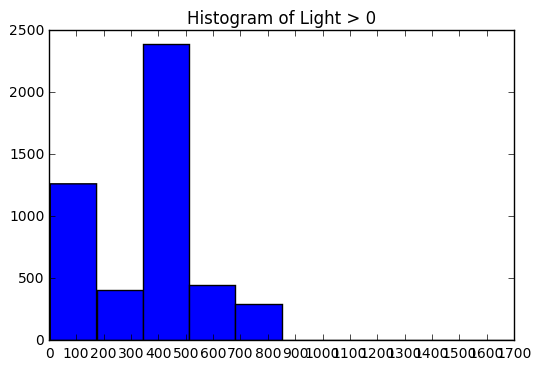

In [11]:
plt.figure(1)
plt.hist(ltemp)
plt.title('Histogram of Light > 0')
plt.locator_params(nbins=20, axis = 'x')

plt.show()

The histogram shown above appears to indicate that thresholding the 'light' variable's values can be converted to a '0/1' binary categorical by converting all values of (light <= 200) to zeroes and all values of (light > 200) to 1's. The following Python code performs the required conversion.

In [12]:
tr_df['light'][tr_df['light'] <= 200] = 0
tr_df['light'][tr_df['light'] > 200] = 1
tr_df['light'].describe()

C:\Users\Hammer\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Hammer\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


count    12417.000000
mean         0.280503
std          0.449263
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: light, dtype: float64

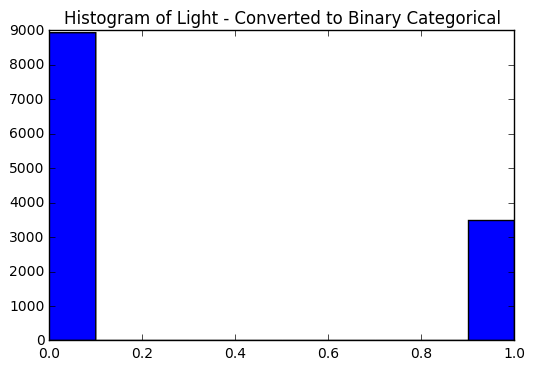

In [13]:
# histogram of light variable after converting to binary categorical
plt.figure(1)
plt.hist(tr_df['light'])
plt.title('Histogram of Light - Converted to Binary Categorical')
plt.locator_params(nbins=5, axis = 'x')
    
plt.show()

As we can see in the histogram shown above, the 'light' variable has now been converted to a binary categorical variable. 

#### CO2 ('CO2')

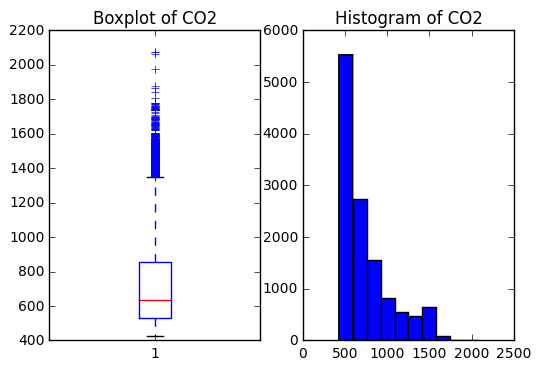

In [14]:
# boxplot and histogram of CO2 variable
plt.figure(1)
plt.subplot(121)
plt.boxplot(tr_df['CO2'])
plt.title('Boxplot of CO2')
plt.xlabel(' ')
    
plt.subplot(122)
plt.hist(tr_df['CO2'])
plt.title('Histogram of CO2')
plt.locator_params(nbins=5, axis = 'x')
    
plt.show()

Plots of the CO2 variable clearly show the right-skewed nature of that variable's distribution. Similar to both the 'temp' and 'humidity' variables, it is unclear whether the skew (as well as the potential multi-modality) is being caused by unusual outliers or by naturally occurring variations in CO2 levels that result from factors such as seasonality or occupancy.

#### Humidity Ratio ('humidratio')

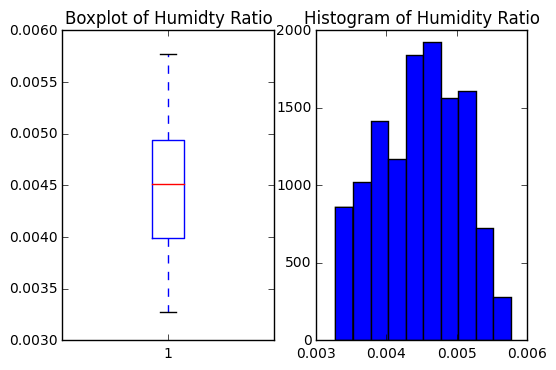

In [15]:
# boxplot and histogram of humidratio variable
plt.figure(1)
plt.subplot(121)
plt.boxplot(tr_df['humidratio'])
plt.title('Boxplot of Humidty Ratio')
plt.xlabel(' ')
    
plt.subplot(122)
plt.hist(tr_df['humidratio'])
plt.title('Histogram of Humidity Ratio')
plt.locator_params(nbins=5, axis = 'x')
    
plt.show()

As was mentioned above, the humidity ratio variable is a derived metric. The plots above show that of the various potential predictor variables provided in the data set the humidity ratio variable's distribution comes closest to approximating a normal distribution.

The skew of some of these distributions may have implications for how we construct our regression models. For example, it may be the case that the fit of a particular regression model will be improved if the skew of one or more of these distributions is reduced via Box-Cox recommended transforms (i.e., log, square root, inverse, etc.). 

A correlation matrix for all non-date variables contained in the data set is provided below:

In [16]:
# correlation matrix
display(tr_df.corr())

,temp,humidity,light,CO2,humidratio,occ
temp,1.000000,-0.337320,0.688204,0.328829,0.121594,0.576418
humidity,-0.337320,1.000000,-0.094131,0.076407,0.891909,-0.042677
light,0.688204,-0.094131,1.000000,0.342275,0.234919,0.906463
CO2,0.328829,0.076407,0.342275,1.000000,0.258695,0.370974
humidratio,0.121594,0.891909,0.234919,0.258695,1.000000,0.242000
occ,0.576418,-0.042677,0.906463,0.370974,0.242000,1.000000


The matrix shows that the 'light' variable is approximately 0.906 correlated with the indoor space having been occupied at the time of an observation. This makes sense intuitively since we would generally expect the amount of lighting within an indoor space to be relatively higher when people are present within the space than when no people are present. The relatively high 0.688 correlation of the 'light' variable with the 'temp' variable is also unsurprising given that indoor light fixtures emit heat when activated, thereby contributing to an increase in the temperature of the indoor space. 

The 0.576 correlation of 'temp' with the space being occupied is also to be expected. Intuitively, we would generally expect an indoor space to be relatively warmer when people are present. The -0.337 correlation of 'temp' and 'humidity' reflects the fact that an increase in air temperature in the presence of a relatively constant amount of airborn moisture will result in a decrease in ambient humidity levels. We would also expect C02 levels to increase when people are present, and the 0.37 correlation of 'CO2' with 'occ' appears to confirm that assumption.

Also of note is the 0.89 correlation between humidity and the humidity ratio variable. Since the humidity ratio variable is in fact partially derived from the humidity value, this high correlation is unsurprising. However, such a high level of correlation between potential predictor variables is indicative of colinearity and one of the two should be ignored for purposes of regression modeling. Of the two, the 'humidratio' demonstrates a higher correlation with the 'occ' response variable (0.242 vs -0.042 for the 'humidity' variable). Therefore, we will exclude the 'humidity' variable from any regression models constructed herein.

The correlation matrix does appear to support the theory that the output from multiple types of sensors might allow us to determine whether or not people are present within a room. In the __Regression Modeling__ section that follows we put that theory to the test.

# Part 3: Regression Modeling

As mentioned in the __Methodology__ section above, three separate regression models are constructed for purposes of attempting to predict whether or not a person is occupying an indoor space based on the sensor reading data provided in the data set. While this type of problem is clearly more suited to binary logistic regression than it is to linear regression, both types of models are constructed as a Python learning exercise. Specifically, two different binary logistic models and one linear model are created, each of which uses the 'occ' occupancy indicator as the response variable and various combinations of the sensor readings as independent variables. Each of the model building efforts is described separately below.

### Model 1: Binary Logistic Regression Model using Forward Selection

The first model makes use of simple forward selection and a logit link function to produce a binary logistic regression model. Specifically, the __Logit__ function from Python's __statsmodels.api__ package is applied, with the results of each iteration checked to determine whether or not the addition of a new predictor variable to the regression model improves the model's performance.

According to the correlation matrix shown in __Part 2__ above, the 'light' variable has the highest correlation with the 'occ' response variable. As such, we start our forward selection with that predictor:

In [17]:
# import required python libraries
import statsmodels.api as sm
from scipy import stats

# import regression model diagnostic functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# sensitivity = recall
from sklearn.metrics import recall_score

In [18]:
# specify the independent variables to be used
train_cols = tr_df.columns[[3]]

x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m1 = logit.fit()
print m1.summary()

y_true = tr_df['occ'].tolist()
preds = m1.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.113193
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12415
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.7960
Time:                        09:43:22   Log-Likelihood:                -1405.5
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
light          9.5787      0.503     19.059      0.000         8.594    10.564
const         -7.7109      0

A summary of the initial model is shown above. As we can see, applying 'light' as the sole predictor of 'occ' yields a binary logistic regression model with a pseudo R-squared value of 0.7960 and a log likelihood of -1405.5. The 0.96 accuracy of this simple model should not be particularly surprising in light of the 0.906 correlation of 'light' with 'occ'. However, we may be able to improve on these results by adding additional predictors to the model. The 'temp' variable is added next since it has the second-highest correlation with 'occ' (0.576).

In [19]:
# specify the independent variables to be used - add 'temp'
train_cols = tr_df.columns[[1,3]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m2 = logit.fit()
print m2.summary()

# diagnostic metrics
preds = m2.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.105720
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12414
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.8095
Time:                        09:43:23   Log-Likelihood:                -1312.7
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
temp          -0.7125      0.054    -13.288      0.000        -0.818    -0.607
light         10.9660      0

The results shown above indicate that though both the Pseudo R-Squared and log likelihood metrics have improved slightly, other performance metrics have not improved as a result of adding the 'temp' variable to the model. Furthermore, the coefficient of the 'temp' variable is negative, a factor that may be an indication of a collinearity conflict between the 'light' and 'temp' variables. Intuitively, we would expect the temperature of an indoor space to increase in the presence of occupants. However, the coefficient of the 'temp' variable indicates that the likelihood of the indoor space being occupied __decreases__ as the temperature reading increases. An examination of the correlation matrix shown in __Part 2__ shows us that 'temp' is in fact 0.688 correlated with 'light'. As such, adding 'temp' to the regression model may be unwise due to the collinearity issues it will introduce. For that reason we will remove 'temp' and proceed with the assessment of the remaining independent variables.

Next, we add the 'CO2' variable to the model based on its 0.37 correlation with 'occ':

In [20]:
# specify the independent variables to be used - 'light' and 'CO2'
train_cols = tr_df.columns[[3, 4]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m3 = logit.fit()
print m3.summary()

# diagnostic metrics
preds = m3.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.097616
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12414
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.8241
Time:                        09:43:23   Log-Likelihood:                -1212.1
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
light         10.6416      0.542     19.634      0.000         9.579    11.704
CO2            0.0047      0

The results shown above indicate that adding 'CO2' to the model improves the Pseudo R-Squared, log likelihood, and all other performance metrics for the model while also proving to be a statistically significant predictor.

Finally, we attempt to add the sole remaining predictor, 'humidratio':

In [21]:
# specify the independent variables to be used - add 'humidratio'
train_cols = tr_df.columns[[3,4,5]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m4 = logit.fit()
print m4.summary()

# diagnostic metrics
preds = m4.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.097412
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12413
Method:                           MLE   Df Model:                            3
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.8244
Time:                        09:43:23   Log-Likelihood:                -1209.6
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
light         10.5863      0.543     19.496      0.000         9.522    11.651
CO2            0.0046      0

As we can see above, the addition of 'humidratio' does, in fact, slightly improve each of the relevant performance metrics (i.e., Pseudo R-Squared, log-likelihood, accuracy, precision, etc.) while proving to be a statistically significant predictor.

#### Model 1 Inferences

We can infer the following from the __Model 1__ coefficients listed above:

- __light__: The higher the amount of light detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __CO2__: The higher the amount of CO2 detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __humidratio__: The higher the humidity ratio detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 


### Model 2: Binary Logistic Regression Model Excluding the 'light' Variable

The results of __Model 1__ showed that the 'light' variable itself can predict more than 96% of the instances of occupancy within the training data set. Though additional statistically significant variables were able to be added to expand __Model 1__ beyond just the 'light' variable, the overall improvement in the accuracy, precision, and other performance metrics was relatively modest. As such, though we were able to expand the model, the increase in complexity that accompanies that expansion might outweigh the associated performance improvement.

The second model therefore excludes the use of the 'light' variable in an attempt to assess the effectiveness of the remaining independent variables in predicting the 'occ' response variable without the presence of the highly correlated 'light' variable. Such a model could be useful in instances when lighting levels do not vary much regardless of whether or not a space is occupied or in instances where installation of a light sensor is not feasible.

Similar to __Model 1__, simple forward selection and a logit link function are used to produce a binary logistic regression model. According to the correlation matrix shown in __Part 2__ above, the 'temp' variable has the highest correlation with the 'occ' response variable of the non-'light' independent variables. As such, we start our forward selection with that predictor:

In [22]:
# specify the independent variables to be used - start with 'temp'
train_cols = tr_df.columns[[1]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m5 = logit.fit()
print m5.summary()

# diagnostic metrics
preds = m5.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.389810
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12415
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.2974
Time:                        09:43:23   Log-Likelihood:                -4840.3
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
temp           1.4678      0.029     50.845      0.000         1.411     1.524
const        -32.4537      0.

Applying 'temp' as the sole predictor of 'occ' yields a binary logistic regression model with a pseudo R-squared value of 0.2974 and a log likelihood of -4840.3. The 0.813 accuracy of this simple model should not be particularly surprising in light of the 0.576 correlation of 'temp' with 'occ'. However, we may be able to improve on these results by adding additional predictors to the model. The 'CO2' variable is added next since it has the next-highest correlation with 'occ' (0.371) after that of the 'temp' variable.

In [23]:
# specify the independent variables to be used - add 'CO2'
train_cols = tr_df.columns[[1,4]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m6 = logit.fit()
print m6.summary()

# diagnostic metrics
preds = m6.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.363277
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12414
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.3453
Time:                        09:43:23   Log-Likelihood:                -4510.8
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
temp           1.3573      0.029     46.846      0.000         1.300     1.414
CO2            0.0021   8.04e

The addition of 'CO2' as an independent variable appears to have improved each of the assessed measures of model fit and performance except that of the ROC-AUC metric which experienced a slight decrease. In particular, both the F1 score and sensitivity metrics show marked improvement when 'CO2' is added to the model. 

Finally, we attempt to add the sole remaining non-'light' predictor, 'humidratio':

In [24]:
# specify the independent variables to be used - add 'humidratio'
train_cols = tr_df.columns[[1,4,5]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(tr_df[train_cols], prepend=False)

# specify the response variable
# logit = sm.Logit(tr_df['occ'], tr_df[train_cols])
logit = sm.Logit(tr_df['occ'], x)
# fit the model
m7 = logit.fit()
print m7.summary()

# diagnostic metrics
preds = m7.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.358829
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    occ   No. Observations:                12417
Model:                          Logit   Df Residuals:                    12413
Method:                           MLE   Df Model:                            3
Date:                Mon, 05 Dec 2016   Pseudo R-squ.:                  0.3533
Time:                        09:43:24   Log-Likelihood:                -4455.6
converged:                       True   LL-Null:                       -6889.6
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
temp           1.2790      0.029     44.866      0.000         1.223     1.335
CO2            0.0018   8.51e

The results shown above indicate that the addition of the 'humidratio' variable to the model has a somewhat mixed effect on its fit and performance. While the Pseudo R-Squared, log likelihood, precision, F1 score, and sensitivity  improve, both the accuracy and ROC-AUC scores decrease slightly. However, the variable proves to be statistically significant, thereby suggesting that its inclusion within the model is warranted.

#### Model 2 Inferences

We can infer the following from the __Model 2__ coefficients listed above:

- __temp__: The higher the temperature is within the indoor space, the more likely it is the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __CO2__: The higher the amount of CO2 detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __humidratio__: The higher the humidity ratio detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

### Model 3: Linear Regression Model Using Forward Selection

While both __Model 1__ and __Model 2__ rely on binary logistic regression, __Model 3__ will make use of ordinary least squares ('OLS') linear regression for purposes of attempting to predict whether or not the indoor space was occupied at the time of each observation. It should be noted that OLS linear regression is not typically used for purposes of predicting a binary response variable due to the fact that OLS can yield numeric results either greater than 1 or less than zero for any binary logistic data set. However, OLS is used here to not only enable a comparison of its performance against that of the binary logistic regression models described above, but to allow for an opportunity to explore and apply some aspects of Python's OLS linear regression capabilities.

As with __Model 1__, we start our OLS linear regression modeling using only the 'light' variable as a predictor of 'occ':

In [25]:
# import OLS function from statsmodels package
from statsmodels.formula.api import ols

m8 = ols('occ ~ light', tr_df).fit()
print(m8.summary()) 

# diagnostic metrics
preds = m8.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

                            OLS Regression Results                            
Dep. Variable:                    occ   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                 5.721e+04
Date:                Mon, 05 Dec 2016   Prob (F-statistic):               0.00
Time:                        09:43:24   Log-Likelihood:                 3591.8
No. Observations:               12417   AIC:                            -7180.
Df Residuals:                   12415   BIC:                            -7165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0004      0.002      0.234      0.8

Applying 'light' as the sole predictor of 'occ' yields a linear regression model with an R-squared value of 0.822, a log likelihood of 3591 and an AIC score of -7180. The performance metrics of this simple model (i.e., accuracy, precision, etc..) compare favorably with the results we obtained via binary logistic regression when using only the 'light' variable as a predictor (see __Model 1__ discussion above). 

The 'CO2' variable is added next since it has the next-highest correlation with 'occ' (0.371) if we exclude the 'temp' variable which was found to be significantly collinear with 'light' during the construction of __Model 1__.

In [26]:
m9 = ols('occ ~ light + CO2', tr_df).fit()
print(m9.summary()) 

# diagnostic metrics
preds = m9.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

                            OLS Regression Results                            
Dep. Variable:                    occ   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 2.943e+04
Date:                Mon, 05 Dec 2016   Prob (F-statistic):               0.00
Time:                        09:43:24   Log-Likelihood:                 3738.9
No. Observations:               12417   AIC:                            -7472.
Df Residuals:                   12414   BIC:                            -7450.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0675      0.004    -15.443      0.0

The addition of the 'CO2' variable to the OLS model appears to slightly improve the fit of the model as evidenced by improvements in the R-Squared and AIC scores. However, the performance of the model appears to be mostly unchanged relative to the OLS model using only 'light' as an independent variable.

Next, we attempt to add 'humidratio' to the OLS model:

In [27]:
m10 = ols('occ ~ light + CO2 + humidratio', tr_df).fit()
print(m10.summary()) 

# diagnostic metrics
preds = m10.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

                            OLS Regression Results                            
Dep. Variable:                    occ   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 1.966e+04
Date:                Mon, 05 Dec 2016   Prob (F-statistic):               0.00
Time:                        09:43:24   Log-Likelihood:                 3750.0
No. Observations:               12417   AIC:                            -7492.
Df Residuals:                   12413   BIC:                            -7462.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1221      0.012     -9.845      0.0

The addition of 'humidratio' slightly improves the fit of the model as evidenced by the minor improvements in the R-Squared and AIC metrics. However, the performance of the model is relatively unchanged. 

A Q-Q plot of the model's residuals reveals a bifurcated residual distribution:

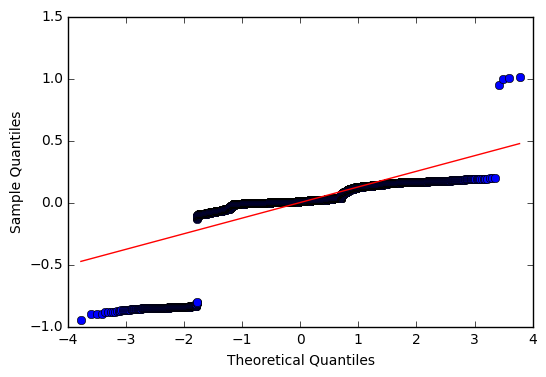

In [28]:
#Q-Q plot for normality
fig1=sm.qqplot(m10.resid, line='r')

The bifurcated nature of the plot likely reflects the fact that the 'occ' response variable is both discrete and binary. As such, we should expect to see a split in the residual plot since the variable they are generated from is not continuous in nature.

The added variable plots shown below for the OLS model also highlight the binary discrete nature of the response variable as evidenced by the distinct, evenly spaced clusters of plot points shown within each.

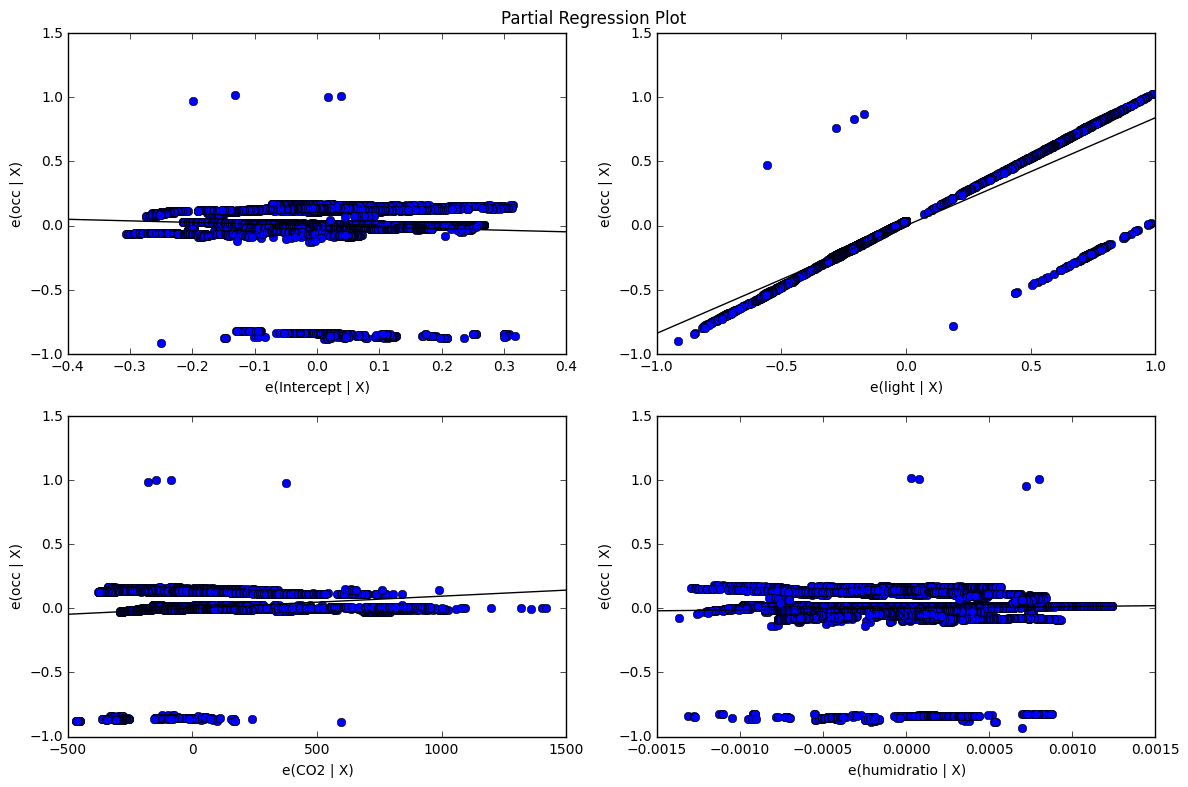

In [29]:
# partial regression / added variable plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(m10, fig=fig)

Python also provides a method for plotting multiple diagnostic plots for a single independent variable relative to the OLS model. Below we make use of the __plot.regress.exog__ function from the __statsmodels__ package to generate such plots for each of the independent variables ('light', 'CO2' and 'humidratio').

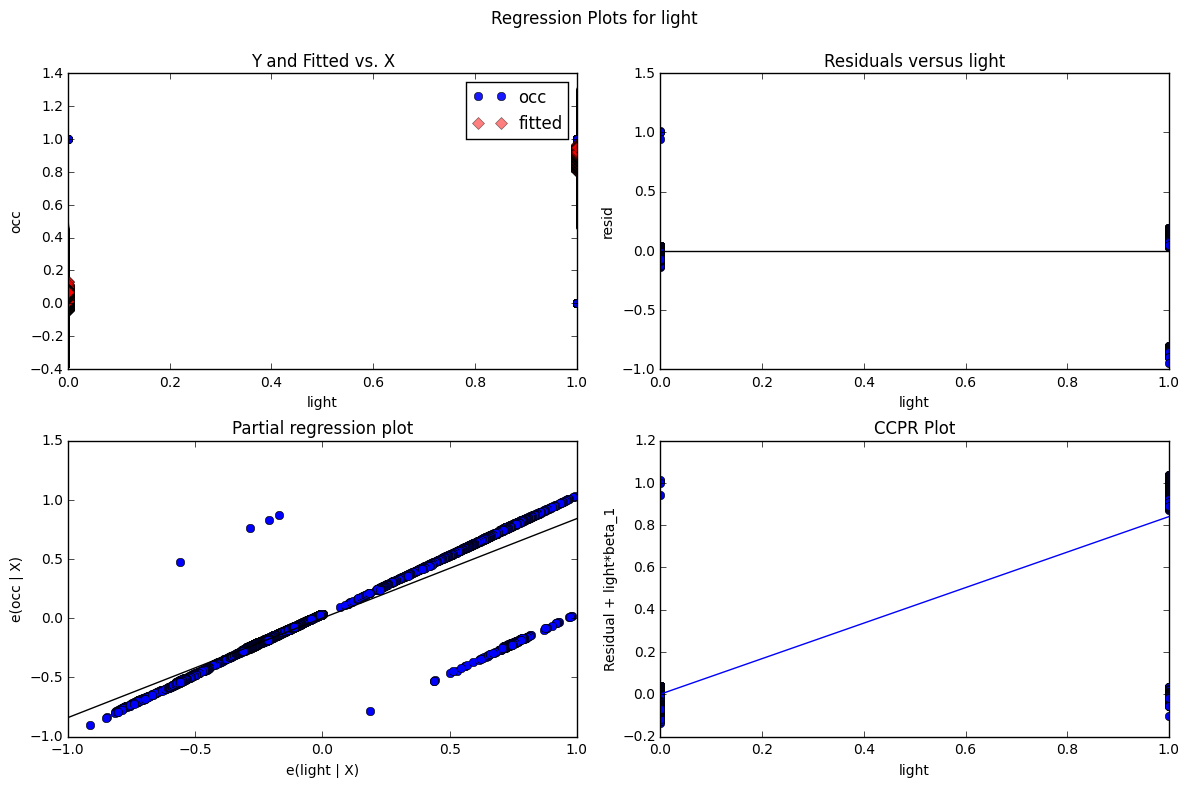

In [30]:
# diagnostic plot for 'light' variable
fig4 = plt.figure(figsize=(12,8)) 
fig4 = sm.graphics.plot_regress_exog(m10, 'light', fig=fig4)

The plots shown above for the binary version of the 'light' variable show how closely correlated it is with the 'occ' response variable as evidenced by the density of the points clustered around the line shown in the partial regression plot. The plots for the 'CO2' variable are shown below.

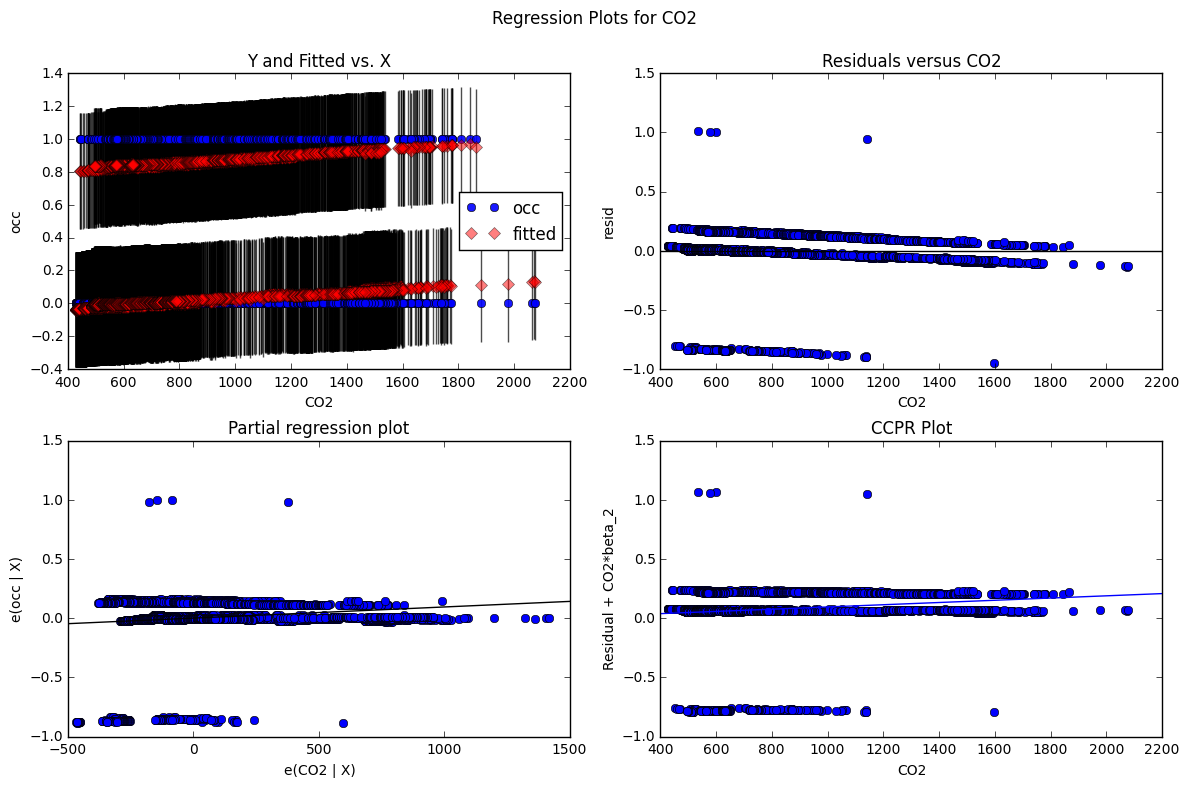

In [31]:
# diagnostic plot for CO2 variable
fig4 = plt.figure(figsize=(12,8)) 
fig4 = sm.graphics.plot_regress_exog(m10, 'CO2', fig=fig4)

The 'occ' vs. 'fitted' plot for the 'CO2' variable shows very clear evidence of the accuracy of the model, with the actual 'occ' values associated with each 'CO2' observation falling well within the indicated confidence intervals, particularly for instances of (occ = 0). Plots for the 'humidratio' variable show demonstrate similar characteristics, as shown below.

In [32]:
# diagnostic plot for humidratio variable
fig5 = plt.figure(figsize=(12,8)) 
fig5 = sm.graphics.plot_regress_exog(m10, 'humidratio', fig=fig4)

#### Model 3 Inferences

We can infer the following from the __Model 3__ coefficients listed above:

- __light__: The higher the amount of light detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __CO2__: The higher the amount of CO2 detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

- __humidratio__: The higher the humidity ratio detected within the indoor space, the more likely the space is to be occupied. This result conforms to what we learned during our data exploration efforts. 

These inferences conform to those of __Model 1__, which made use of the same set of independent variables.

With each of our three models complete, we are now ready to proceed with the task of selecting a preferred model. 

# Model Selection

The chart below summarizes the model statistics for each of the three models. The models are listed from left to right in accordance with the order in which they were described in __Part 3__. 

| Metric        |  Model 1(Logit) | Model 2 (Logit)  | Model 3 (OLS) 
| ------------- | --------------- | ---------------- | --------------
| # Predictors  |      3          |     3            |      3
| Pseudo R^2    |    0.8244       |   0.3533         |    (-)
| R^2           |     (-)         |     (-)          |    0.826
| Log Likelih.  |    -1209.6      |   -4455.6        |    3750
| Accuracy      |    0.9622       |   0.8176         |    0.9621
| Precision     |    0.9587       |   0.6785         |    0.9585
| ROC-AUC       |    0.9877       |   0.8917         |    0.9875
| F1 Score      |    0.9278       |   0.5761         |    0.9277
| Sensitivity   |    0.9976       |   0.5094         |    0.9986

As we can see in the table, Models 1 and 3 are fairly similar in their performance metrics. However, the differences in their performance metrics are marginal at best. Of the two, Model 1 is likely preferable due to its reliance on a binary logistic regression approach as opposed to __Model 3__ which makes use of an ordinary least squares approach for predicting the binary response variable.

__Model 2__ appears to underperform each of the other two models relative to every performance metric we've evaluated. However, the virtue of __Model 2__ is that it does not rely upon the 'light' variable as a predictor. As mentioned earlier, 'light' is very highly correlated with the 'occ' response variable and is also collinear with the 'temp' variable to a large extent. As such, __Model 2__ clearly has value as an alternative to either __Model 1__ or __Model 3__, each of which incorporate 'light' as a predictor. That said, for purposes of this project __Model 1__ is selected as the preferred model for purposes of predicting the 'occ' response variable in the test data set.

### Predictions for the Test Data Set

Applying __Model 1__ to the test data set yields the following results: 


In [33]:
# specify the independent variables to be used - add 'humidratio'
test_cols = test_df.columns[[3,4,5]]

# statsmodel requires that a constant be added to predictors
x = sm.add_constant(test_df[test_cols], prepend=False)

# specify the response variable
logit = sm.Logit(test_df['occ'], x)
# fit the model
mtest = logit.fit()

# diagnostic metrics
y_true = test_df['occ'].tolist()
preds = mtest.predict()
y_pred = np.round(preds).tolist()
    
print "Accuracy = ", accuracy_score(y_true, y_pred)
print "Precision = ", average_precision_score(y_true, preds)
print "ROC-AUC = ", roc_auc_score(y_true, preds)
print "F1 Score = ", f1_score(y_true, y_pred, average = 'binary')
# recall = sensitivity
print "Sensitivity = ", recall_score(y_true, y_pred, average = 'binary')

Optimization terminated successfully.
         Current function value: 0.067103
         Iterations 12
Accuracy =  0.988087928282
Precision =  0.947891975451
ROC-AUC =  0.993221432368
F1 Score =  0.972606608303
Sensitivity =  0.995951417004


The performance of the __Model 1__ on the test data appears to be very good. In fact, the accuracy of the model when applied to the test data slightly exceeds the model's performance on the training data.

### Conclusion

After developing 3 distinct models using both binary logistic regression and ordinary least square regression, __Model 1__ was selected as the preferred model based on a comparison of a variety of model fit and performance metrics. Though the training data set presented multiple collinearity issues amongst the available independent predictor variables that led to the exclusion of two potential predictors ('humidity' and 'temp'), __Model 1__ demonstrated very high measures of accuracy, precision, ROC-AUC, F1, and sensitivity, thereby indicating that the use of light, CO2, and humidity ratio data obtained from indoor sensors may viably be used to predict whether or not an indoor space is occupied by one or more people.

Furthermore, our model building efforts demonstrated that a binary regression model comprised of temperature, CO2, and humidity ratio data obtained from indoor sensors (see __Model 2__) might also be an effective tool for predicting whether or not an indoor space is occupied. Such a model might be useful when data from light sensors either cannot be collected (e.g., the indoor space always lacks light or maintains a constant level of light at all times). Further research could include changing the models constructed herein to test the efficacy of the 'humidity' variable as a predictor in place of the collinear 'humidity ratio' variable, or extending the models to include components of the 'date' field provided in the data sets (e.g., the 'hour' component) as independent predictor variables.